In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings 
import matplotlib.font_manager as fm
import os
import openpyxl

from tensorflow.keras.layers import GRU, Input, Dropout, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.activations import tanh
from tensorflow.keras.models import Model
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

warnings.simplefilter(action='ignore', category=pd.errors.SettingWithCopyWarning)
warnings.filterwarnings('ignore')

In [4]:
def pre_process(df):
    df['입고일'] = pd.to_datetime(df['입고일'])
    df = df[~((df['매입량'].notnull()) & (df['입고량(매입량)'] != df['매입량']))]
    df.drop(columns = ['매입량'], inplace = True)
    df = df[(df['규격'] == '중고') | (df['규격'] == '신품')]
    df = df[df['조달구분'] != '사내가공']
    df = df[df['수불방법'] != '예외']
    df = df[df['수불유형'] == '구매입고']
    df = df[df['발주형태'] == '매입']
    df = df[df['입고단가(매입가)']> 1000]

    df_new = df.copy()
    df_new['총액'] = df_new['입고량(매입량)'] * df_new['입고단가(매입가)']
    df_new['차액'] = df_new['합계금액(부대비포함)'] - df_new['총액']
    df_new = df_new[~((df_new['차액']>=1000) | (df_new['차액'] <= -1000))]

    result = df_new.drop_duplicates(subset=['품목명', '규격', '입고일']).groupby(['품목명', '규격']).size().reset_index(name='발생횟수')
    result  = result.sort_values(by='발생횟수',ascending=False)

    ddate = df_new['입고일'].unique()
    ddate = len(ddate)/3
    top_new = result[result['발생횟수']>= ddate][['품목명', '규격']]
    
    filtered_df  = df_new.merge(top_new, on=['품목명', '규격'], how='inner')
    filtered_df  = filtered_df[~((filtered_df ['거래처']=='월드용산(매입용)') | (filtered_df ['거래처']=='월드와이드메모리(서울지점)'))]
    processed_df = filtered_df[(filtered_df ['거래처']=='월드홈피매입') | (filtered_df ['거래처']=='컴퓨존매입용')]

    return processed_df

In [5]:
def make_seq_df(df):
    grouping_columns = ['품목명'] # 그룹핑 변수 list
    df_seq = df.pivot_table(index=grouping_columns, columns='입고일', values='입고단가(매입가)', aggfunc='mean').reset_index().rename_axis(None, axis=1)
    df_seq = df_seq.dropna(axis=1 ,how='all') # 컬럼의 값이 모두 결측일때 컬럼 드롭
    
    return df_seq

def find_outlier(price):
    df = pd.DataFrame(price, columns=['price'])
    df_clean = df['price'].dropna()
    Q1 = df_clean.quantile(0.25)
    Q3 = df_clean.quantile(0.75)
    IQR = Q3 - Q1
    # 이상치의 기준을 2.2로 완화
    lower_bound = Q1 - 2.2 * IQR
    upper_bound = Q3 + 2.2 * IQR
    df['price'] = df['price'].apply(lambda x: np.nan if (x < lower_bound or x > upper_bound) else x)
    
    return df['price'].values  # 원래의 배열 형태로 반환

def seq_df_filter(df_seq):
    for idx in range(len(df_seq)):
        price = df_seq.iloc[idx, 1:].values
        updated_price = find_outlier(price)
        df_seq.iloc[idx, 1:] = updated_price
    
    len_date = df_seq.shape[1] #컬럼길이
    df_seq = df_seq[~(df_seq.isnull().sum(axis=1) >= len_date/3)] # 1/3 이상이 결측치일때 제거
    df_seq = df_seq.dropna(axis=1 ,how='all') # 컬럼의 값이 모두 결측일때 컬럼 드롭

    df_seq1 = df_seq['품목명']
    df_seq2 = df_seq.iloc[:, 1:].fillna(method='ffill', axis=1).fillna(method='bfill', axis=1) 
    df_seq = pd.concat([df_seq1, df_seq2], axis=1)
    
    return df_seq

In [6]:
directory  = os.getcwd()
print('🌍 매입단가 예측 프로그램을 시작합니다.')
print(f'현재 경로를 표시합니다: {directory}')

FILE_NAME = '매입내역.xlsx'
df = pd.read_excel(f'{directory}/{FILE_NAME}')

processed_df = pre_process(df)
df_seq = make_seq_df(processed_df)
df_seq = seq_df_filter(df_seq)

🌍 매입단가 예측 프로그램을 시작합니다.
현재 경로를 표시합니다: YOUR PATH

----------------------------------

In [7]:
# def minmax_scale_row(row):
#     min_val = row.min()
#     max_val = row.max()
#     if max_val - min_val == 0:
#         return row  # 값이 모두 같을 경우 변경하지 않음
#     return (row - min_val) / (max_val - min_val)

def minmax_scale_row(data):
    scaler = MinMaxScaler()
    data = scaler.fit_transform(data.values.reshape(-1, 1))
    data = data.reshape(-1)
    return data

def data_scaler(df_seq):
    df_seq_scaled = df_seq.iloc[:, 1:].apply(minmax_scale_row, axis=1)
    df_seq_scaled = pd.concat([df_seq['품목명'], df_seq_scaled], axis=1).reset_index(drop=True)
    return df_seq_scaled

def calculate_mean(row):
    return sum(row[:30]) / len(row[:30])

def scale_filter(df_seq):
    df_seq_scaled = data_scaler(df_seq)
    # df_seq_scaled = df_seq_scaled[df_seq_scaled.iloc[:,1:].mean(axis=1) <= 1] # 정규화가 안됐을 경우 제거
    # df_seq_scaled = df_seq_scaled[df_seq_scaled.iloc[:,1:30].mean(axis=1) >= 0.6].reset_index(drop=True) #첫 30개 평균이 0.6이 넘지 않을 경우 제거
    df_seq_scaled['평균'] = df_seq_scaled[0].apply(calculate_mean)
    df_seq_scaled = df_seq_scaled[df_seq_scaled['평균']>= 0.6].reset_index(drop=True)
    df_seq_scaled.drop(columns = ['평균'], inplace = True)
    return df_seq_scaled

In [8]:
def make_sequence(data, window_size, date):
    feature_list = [] # 학습데이터 window_size일
    label_list = [] # 예측데이터 date일

# 데이터의 길이를 넘지 않도록 시퀀스 생성
    for i in range(0, len(data) - window_size - date + 1, window_size + date):
        features = data[i:i + window_size]
        labels = data[i + window_size:i + window_size + date]
        
        feature_list.append(features)
        label_list.append(labels)

    return feature_list, label_list


def make_data(X,y,train_rate):
    X = np.array(X)
    y = np.array(y)

    indices = np.arange(len(X))
    np.random.seed(42)  # 랜덤 시드 고정
    np.random.shuffle(indices)

    # 원하는 비율로 학습 및 테스트 인덱스 분할
    split_index = int(len(indices) * train_rate)  # rate% 학습 데이터, (1-rate)% 테스트 데이터
    train_indices = indices[:split_index]
    test_indices = indices[split_index:]

    # 순서를 유지하기 위해 인덱스를 정렬
    train_indices.sort()
    test_indices.sort()

    # 인덱스를 사용해 학습 및 테스트 데이터 생성
    x_train, x_test = X[train_indices], X[test_indices]
    y_train, y_test = y[train_indices], y[test_indices]

    # 데이터 차원 맞추기 (GRU 입력 형식에 맞게 변경)
    x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], 1)).astype('float32')
    x_test = x_test.reshape((x_test.shape[0], x_test.shape[1], 1)).astype('float32')
    y_train = y_train.astype('float32')
    y_test = y_test.astype('float32')

    return x_train, x_test, y_train, y_test

In [9]:
def learning_GRU(x_train, x_test, y_train, y_test):
    # 모델 정의
    input_layer = Input(shape=(x_train.shape[1], 1))
    x = GRU(1024, activation='tanh')(input_layer)
    x = Dropout(0.3)(x)
    x = Dense(1024, activation='relu')(x)
    x = Dense(1024, activation='relu')(x)
    x = Dropout(0.3)(x)
    x = Dense(512, activation='relu')(x)
    x = Dense(256, activation='relu')(x)
    output_layer = Dense(y_train.shape[1])(x)

    model = Model(inputs=input_layer, outputs=output_layer)
    model.compile(loss='mae', optimizer=Adam(learning_rate=0.001))

    # 학습 조기 종료 콜백 설정
    early_stopping_callback = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50, restore_best_weights=True)

    # 모델 학습
    history = model.fit(x_train, y_train, epochs=100, batch_size=128,
                        validation_split=0.1, callbacks=[early_stopping_callback])

    # 학습 및 검증 손실 시각화
    history_dict = history.history
    loss = history_dict['loss']
    val_loss = history_dict['val_loss']

    epochs = range(1, len(loss) + 1)
    plt.figure(figsize=(12, 6), facecolor='white')
    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss') 
    plt.show()

    return model

In [10]:
def test_model(code_name, model20, x_test20, y_test20, last20, model25, x_test25, y_test25, last25, max_val, min_val):
    predicted_values20 = model20.predict(x_test20)
    y_test_flat20 = y_test20.flatten()
    predicted_values_flat20 = predicted_values20.flatten()
    y_test_inverse20 = y_test_flat20.flatten()
    y_pred_inverse20 = predicted_values_flat20.flatten()

    predicted_values25 = model25.predict(x_test25)
    y_test_flat25 = y_test25.flatten()
    predicted_values_flat25 = predicted_values25.flatten()
    y_test_inverse25 = y_test_flat25.flatten()
    y_pred_inverse25 = predicted_values_flat25.flatten()

    r2_20 = r2_score(y_test_inverse20, y_pred_inverse20)
    r2_25 = r2_score(y_test_inverse25, y_pred_inverse25)

    print("➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖")
    if round(r2_20,4) >= round(r2_25,4):
        print('📊 20일 학습, 5일 예측 모델의 성능이 더 우수합니다.')
        print("🔔 20일 학습, 5일 예측 모델을 사용합니다.")
        print_graph(code_name, y_test_flat20, predicted_values_flat20, y_test_inverse20, y_pred_inverse20, max_val, min_val)
        print_After5days(code_name, model20, last20, max_val, min_val)
    else:
        print('📊 25일 학습, 5일 예측 모델의 성능이 더 우수합니다.')
        print("🔔 25일 학습, 5일 예측 모델을 사용합니다.")
        print_graph(code_name, y_test_flat25, predicted_values_flat25, y_test_inverse25, y_pred_inverse25, max_val, min_val)
        print_After5days(code_name, model25, last25, max_val, min_val)

def print_graph(code_name, y_test_flat, predicted_values_flat, y_test_inverse, y_pred_inverse, max_val, min_val):

    r2 = r2_score(y_test_inverse, y_pred_inverse)
    rmse = np.sqrt(mean_squared_error(y_test_inverse, y_pred_inverse))
    mae = mean_absolute_error(y_test_inverse, y_pred_inverse)

    actual_y_test_flat = y_test_flat * (max_val - min_val) + min_val
    actual_predicted_values_flat = predicted_values_flat * (max_val - min_val) + min_val
    plt.clf()  # 현재 Figure 내용만 지움
    plt.rcParams['font.family'] ='Malgun Gothic'
    
    # 예측값과 실제값 시각화
    plt.figure(figsize=(12, 6))
    plt.plot(range(1, len(actual_y_test_flat)+1), actual_y_test_flat, label='Actual Values', marker='o')
    plt.plot(range(1, len(actual_predicted_values_flat)+1), actual_predicted_values_flat, label='Predicted Values', marker='x')

    # 그래프 설정
    plt.title('Actual vs Predicted Values')
    plt.xlabel('Time Step')
    plt.ylabel('Value')
    plt.legend()
    plt.grid(True)
    plt.show()

    # 성능 측정
    print(' ')
    print(f"📊 선택한 품목: {code_name}의 예측 성능")
    print('R2:', round(r2,4))
    print('RMSE:', round(rmse,4))
    print('MAE:', round(mae,4))


def print_After5days(code_name, model, lastdata, max_val, min_val):
    predicted_values = model.predict(lastdata)
    predicted_values = predicted_values.flatten()

    actual_value = predicted_values * (max_val - min_val) + min_val

    plt.rcParams['font.family'] ='Malgun Gothic'
    plt.figure(figsize=(8, 6))

    days = range(1, 6)  # 1부터 5까지의 일자 생성
    plt.plot(days, actual_value, marker='o')

    for i, value in enumerate(actual_value):
        plt.annotate(f'{value:.2f}',  # 소수점 두 자리까지 표시
                     (days[i], actual_value[i]),  # 해당 데이터 포인트 위치
                     textcoords="offset points",  # 텍스트 위치의 기준 정의
                     xytext=(0,15),  # 텍스트의 x, y 방향 오프셋(위치 조정)
                     ha='center',  # 가로 정렬
                     va='bottom',  # 세로 정렬
                     color='black',  # 텍스트 색상
                     fontsize=10,  # 텍스트 크기
                     bbox=dict(boxstyle="round,pad=0.3", facecolor='yellow', edgecolor='none', alpha=0.5))  # 배경색


    plt.xticks(days, [f"Day {i}" for i in days])
    plt.xlabel('Future Date')
    plt.ylabel('Predicted Price')
    plt.title(f'{code_name} 향후 5일의 예측가')
    plt.show()

------------------

In [19]:
def print_id():
    print("✅ 단가 예측이 가능한 품목명:")
    print("번호   품목명")
    for idx, row in df_seq_scaled.iterrows():
        print_idx= idx+1
        print(print_idx, ' ', row['품목명'])  

    while True:
        print(' ')
        input_idx = input(">>> 예측을 진행할 품목의 번호를 입력하세요:  ").strip()
        print(' ')
        
        if input_idx.isdigit() and int(input_idx) - 1 in df_seq_scaled.index:
            data_idx = int(input_idx) - 1
            code_name = df_seq_scaled.iloc[data_idx]['품목명']

            origin_data = df_seq[df_seq['품목명']==code_name].iloc[:,1:].T
            data = df_seq_scaled.iloc[int(data_idx),1]

            min_max_values = back2origin[back2origin['품목명'] == code_name]
            max_val = min_max_values['Max'].values
            min_val = min_max_values['Min'].values

            print(f"✅ 선택한 품목명: {code_name} ✅")

            plt.rcParams['font.family'] ='Malgun Gothic'
            plt.figure(figsize=(8, 6))
            plt.plot(origin_data)
            plt.xlabel('Date')
            plt.ylabel('Price')
            plt.title(f'{code_name}의 매입단가')
            plt.show()

            return data, min_val, max_val, code_name
        else:
            print("⚠️ 올바른 번호를 입력하세요.")

In [24]:
def model(data, min_val, max_val, code_name):
    X20, y20 = make_sequence(data, 20, 5)
    last20 = data[-20:]
    last20 = last20.reshape((1, 20, 1)).astype('float32')

    X25, y25 = make_sequence(data, 25, 5)
    last25 = data[-25:]
    last25 = last25.reshape((1, 25, 1)).astype('float32')

    x_train20, x_test20, y_train20, y_test20 = make_data(X20,y20,0.8)
    x_train25, x_test25, y_train25, y_test25 = make_data(X25,y25,0.8)

    model20 = learning_GRU(x_train20, x_test20, y_train20, y_test20)
    model25 = learning_GRU(x_train25, x_test25, y_train25, y_test25)

    test_model(code_name, model20, x_test20, y_test20, last20, model25, x_test25, y_test25, last25, max_val, min_val)

    while True:
        print("➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖")
        print('1: 품목 재선택')
        print('*: 프로그램 종료')

        menu_choice = input(">>>>> 메뉴를 선택하세요 (1, *): ").strip()
        print(' ')

        if menu_choice == '1':
            return 'restart'
        
        elif  menu_choice == '*':
            confirm_exit = input("정말 종료하시겠습니까? (y/n): ").strip().lower()
            if confirm_exit == 'y':
                print("⛔ 프로그램을 종료합니다.")
                input("🔔 Enter 키를 누르면 프로그램이 종료됩니다.")
                return 'exit'
                break
            else:
                print("💡 프로그램을 계속 실행합니다.")

        else:
            print("⚠️ 올바른 메뉴를 선택하세요.")


✅ 단가 예측이 가능한 품목명:
번호   품목명
1   120G SSD
2   250G SSD
3   8G DDR3 삼성 12800
4   8G DDR4 삼성 17000
5   8G DDR4 삼성 19200
6   8G DDR4 삼성 21300
7   8G DDR4 외산
8   보드 H81
 
✅ 선택한 품목명: 8G DDR3 삼성 12800 ✅


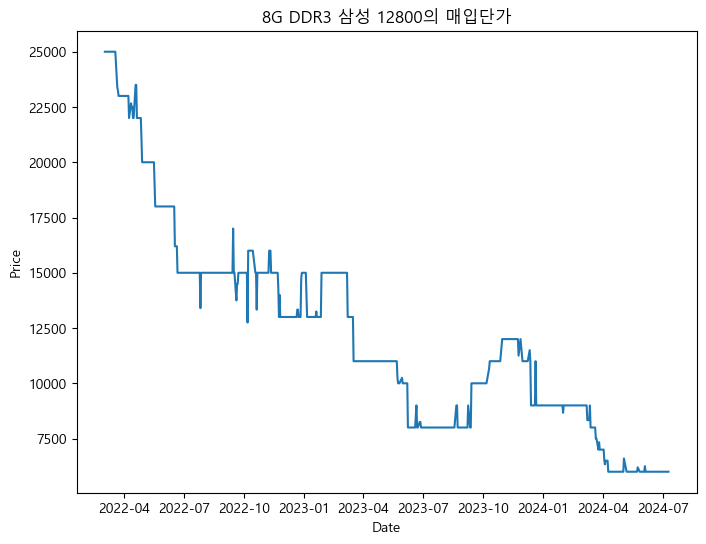

Epoch 1/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.3685 - val_loss: 0.0164
Epoch 2/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - loss: 0.3020 - val_loss: 0.0758
Epoch 3/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - loss: 0.0921 - val_loss: 0.2037
Epoch 4/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - loss: 0.6493 - val_loss: 0.0614
Epoch 5/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - loss: 0.0938 - val_loss: 0.0334
Epoch 6/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - loss: 0.1934 - val_loss: 0.0317
Epoch 7/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - loss: 0.2420 - val_loss: 0.0361
Epoch 8/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - loss: 0.2431 - val_loss: 0.0453
Epoch 9/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - loss: 0.2256 - val_loss: 0.0617
Epoch 10/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - loss: 0.1903 - val_loss: 0.0913
Epoch 11/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - loss: 0.1256 - val_loss: 0.1440
Epoch 12/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - loss: 0.1049

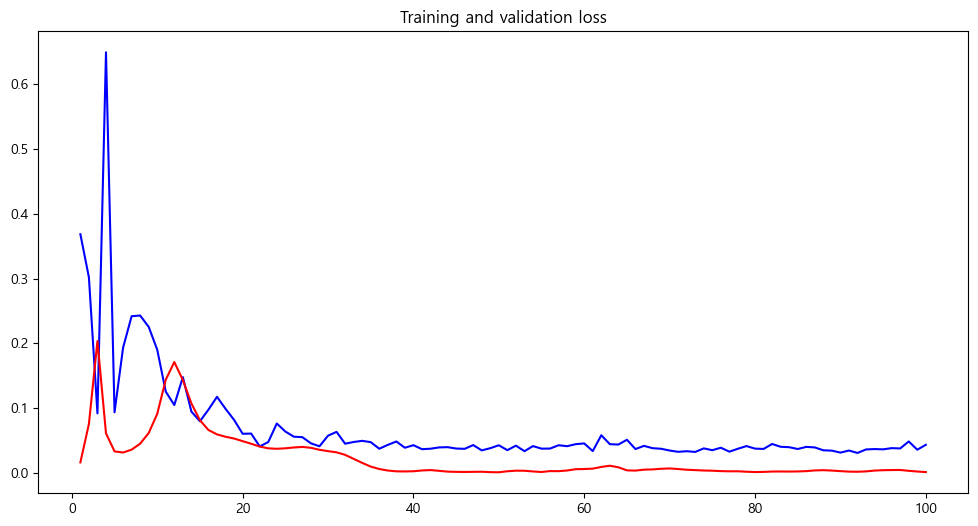

Epoch 1/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 0.3591 - val_loss: 0.0240
Epoch 2/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - loss: 0.2656 - val_loss: 0.1227
Epoch 3/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - loss: 0.1447 - val_loss: 0.0532
Epoch 4/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step - loss: 0.1544 - val_loss: 0.0525
Epoch 5/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step - loss: 0.1697 - val_loss: 0.0733
Epoch 6/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step - loss: 0.1160 - val_loss: 0.1193
Epoch 7/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - loss: 0.0954 - val_loss: 0.1106
Epoch 8/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - loss: 0.0718 - val_loss: 0.0835
Epoch 9/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step - loss: 0.0727 - val_loss: 0.0729
Epoch 10/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - loss: 0.0652 - val_loss: 0.0715
Epoch 11/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step - loss: 0.0489 - val_loss: 0.0695
Epoch 12/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0566

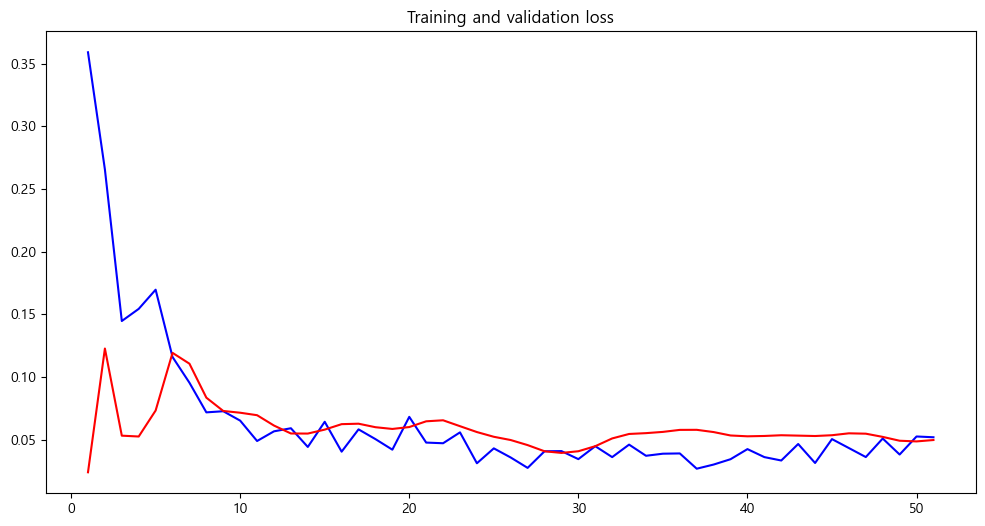

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step
➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖
📊 20일 학습, 5일 예측 모델의 성능이 더 우수합니다.
🔔 20일 학습, 5일 예측 모델을 사용합니다.


<Figure size 640x480 with 0 Axes>

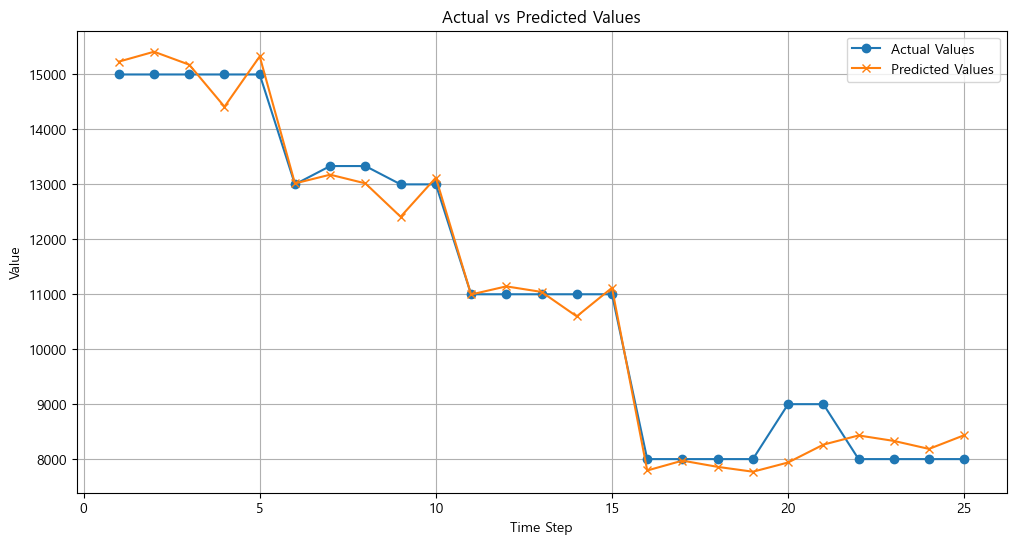

 
📊 선택한 품목: 8G DDR3 삼성 12800의 예측 성능
R2: 0.9797
RMSE: 0.0202
MAE: 0.0157
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 303ms/step


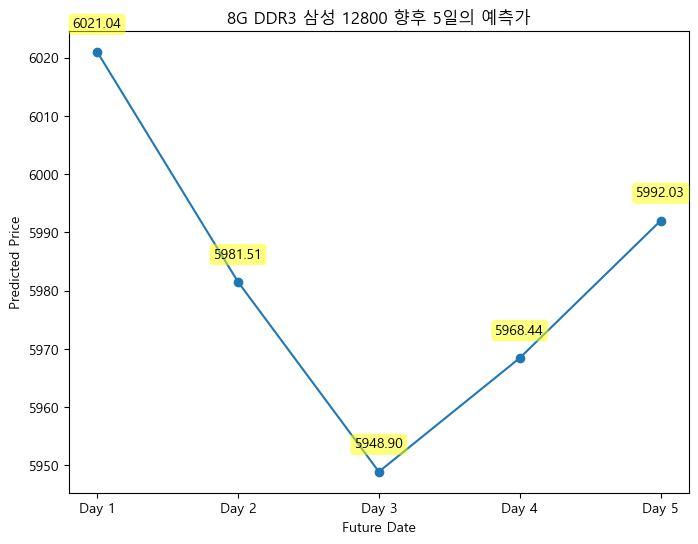

➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖
1: 품목 재선택
*: 프로그램 종료
✅ 단가 예측이 가능한 품목명:
번호   품목명
1   120G SSD
2   250G SSD
3   8G DDR3 삼성 12800
4   8G DDR4 삼성 17000
5   8G DDR4 삼성 19200
6   8G DDR4 삼성 21300
7   8G DDR4 외산
8   보드 H81
 
✅ 선택한 품목명: 8G DDR3 삼성 12800 ✅


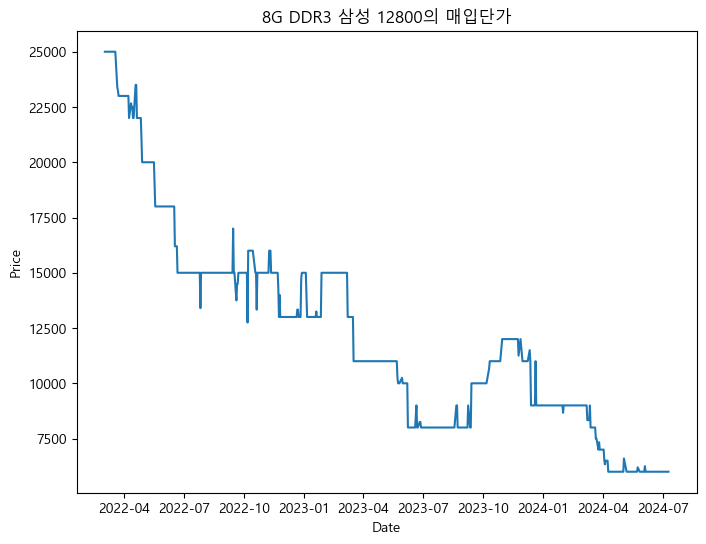

Epoch 1/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.3662 - val_loss: 0.0199
Epoch 2/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - loss: 0.2869 - val_loss: 0.0989
Epoch 3/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - loss: 0.0928 - val_loss: 0.0611
Epoch 4/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - loss: 0.1036 - val_loss: 0.0824
Epoch 5/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - loss: 0.1183 - val_loss: 0.0622
Epoch 6/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - loss: 0.0804 - val_loss: 0.0437
Epoch 7/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - loss: 0.0786 - val_loss: 0.0455
Epoch 8/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - loss: 0.0479 - val_loss: 0.0447
Epoch 9/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - loss: 0.0556 - val_loss: 0.0415
Epoch 10/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - loss: 0.0502 - val_loss: 0.0380
Epoch 11/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - loss: 0.0417 - val_loss: 0.0376
Epoch 12/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - loss: 0.0486

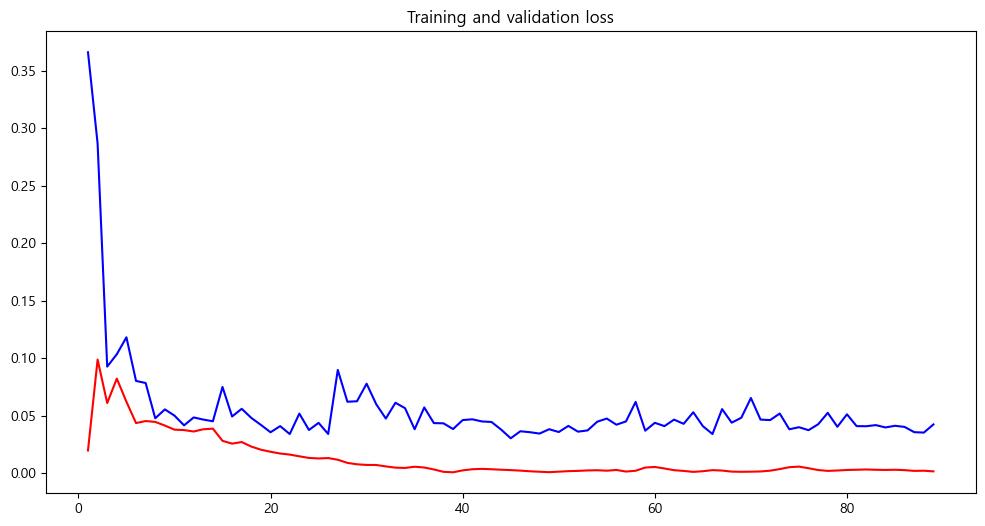

Epoch 1/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 0.3609 - val_loss: 0.0208
Epoch 2/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step - loss: 0.2771 - val_loss: 0.1055
Epoch 3/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - loss: 0.1241 - val_loss: 0.0677
Epoch 4/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step - loss: 0.0961 - val_loss: 0.0960
Epoch 5/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step - loss: 0.0897 - val_loss: 0.0752
Epoch 6/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step - loss: 0.0702 - val_loss: 0.0600
Epoch 7/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step - loss: 0.0652 - val_loss: 0.0609
Epoch 8/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step - loss: 0.0485 - val_loss: 0.0594
Epoch 9/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step - loss: 0.0480 - val_loss: 0.0565
Epoch 10/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - loss: 0.0487 - val_loss: 0.0603
Epoch 11/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - loss: 0.0424 - val_loss: 0.0643
Epoch 12/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step - loss: 0.0552

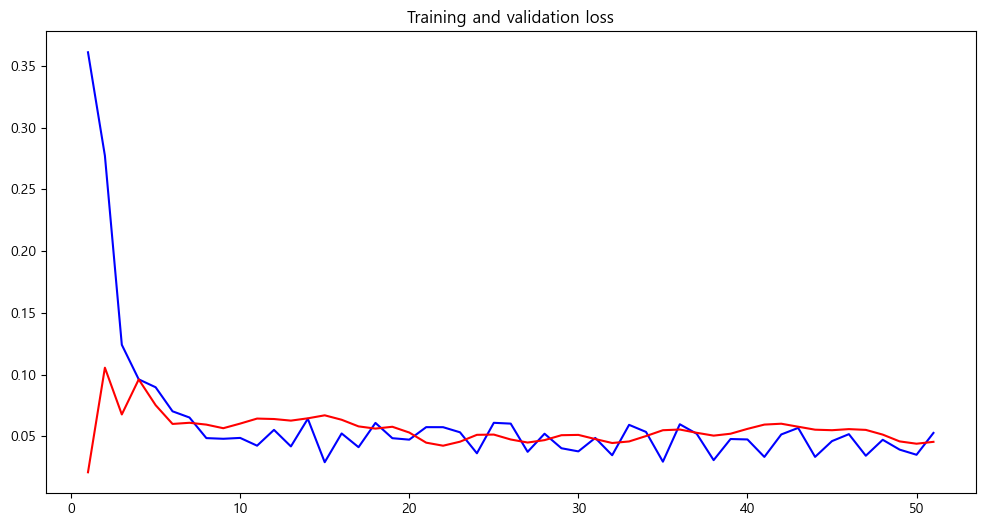

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step
➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖
📊 20일 학습, 5일 예측 모델의 성능이 더 우수합니다.
🔔 20일 학습, 5일 예측 모델을 사용합니다.


<Figure size 640x480 with 0 Axes>

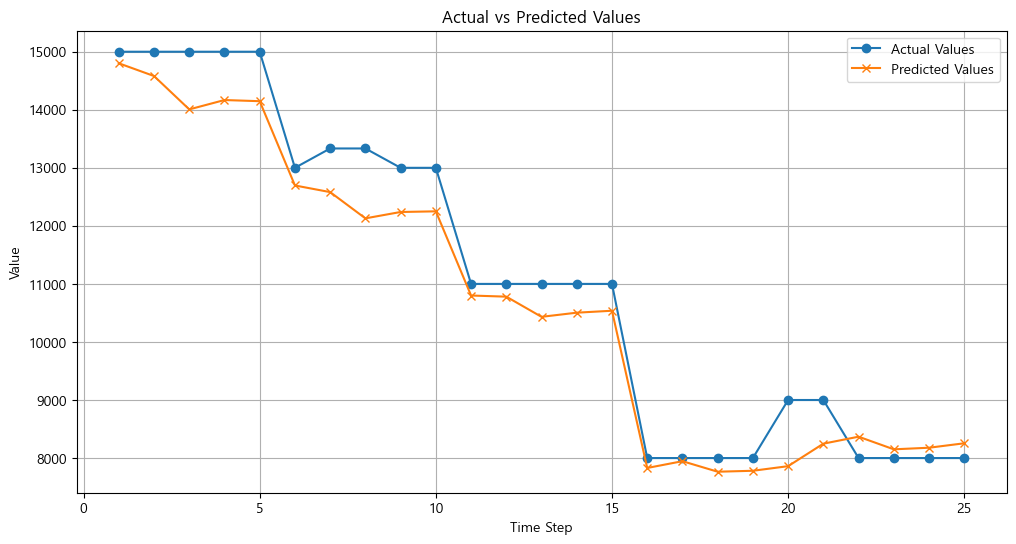

 
📊 선택한 품목: 8G DDR3 삼성 12800의 예측 성능
R2: 0.9507
RMSE: 0.0316
MAE: 0.0264
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


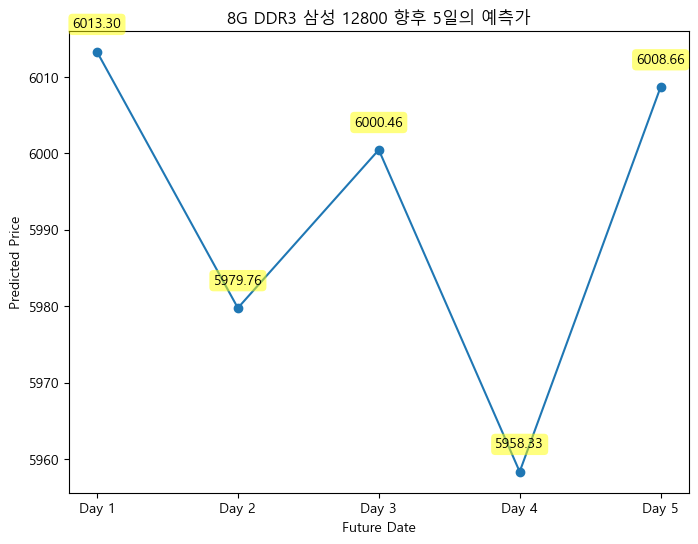

➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖
1: 품목 재선택
*: 프로그램 종료
💡 프로그램을 계속 실행합니다.
➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖
1: 품목 재선택
*: 프로그램 종료
⛔ 프로그램을 종료합니다.


In [25]:
def main_flow():
    while True:
        data, min_val, max_val, code_name = print_id()

        while True:
            menu = model(data, min_val, max_val , code_name)
            if menu == 'exit':
                return 
            if menu == 'restart': # 품목 재선택
                break
        

df_seq_scaled = scale_filter(df_seq)

back2origin = pd.concat([df_seq['품목명'],df_seq.iloc[:,1:].max(axis=1),df_seq.iloc[:,1:].min(axis=1)],axis=1)
back2origin.columns = ['품목명','Max','Min']
back2origin = back2origin[back2origin['품목명'].isin(df_seq_scaled['품목명'])].reset_index(drop=True)

main_flow()